In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import alexnet

from lib.datasets import datasets

cuda = torch.cuda.is_available()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def empty_classifier(num_classes=1000):
    return nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classes),
        nn.LogSoftmax()
    )

# TODO: Move those to lib.utils..

def compute_error_rate(model, data_loader, cuda=True):
    model.eval()
    num_errs = 0.0
    num_examples = 0
    for x, y in data_loader:
        y = y.type(torch.LongTensor)
        if cuda:
            x = x.cuda()
            y = y.cuda()
        with torch.no_grad():
            outputs = model.forward(x)
            _, predictions = outputs.max(dim=1)
            num_errs += (predictions != y).sum().item()
            num_examples += x.size(0)
    return 100.0 * num_errs / num_examples

def train(model, data_loaders, optimizer, criterion, num_epochs=1,
          log_every=100, cuda=True):
    if cuda:
        model.cuda()
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {'train_losses': [], 'train_errs': [], 'val_errs': []}
    print('Training the model!')
    print('You can interrupt it at any time.')
    try:
        while epoch < num_epochs:
            model.train()
            # model.train_mode()
            epoch += 1
            for x, y in data_loaders['train']:
                y = y.type(torch.LongTensor)
                
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                iter_ += 1

                optimizer.zero_grad()
                out = model.forward(x)
                loss = criterion(out, y)
                loss.backward()
                optimizer.step()
                _, predictions = out.max(dim=1)
                err_rate = 100.0 * (predictions != y).sum() / out.size(0)

                history['train_losses'].append(loss.item())
                history['train_errs'].append(err_rate.item())

                if iter_ % log_every == 0:
                    print("Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%" \
                          .format(iter_, loss.item(), err_rate))

            val_err_rate = compute_error_rate(model, data_loaders['test'], cuda)
            history['val_errs'].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
                best_epoch = epoch
                best_val_err = val_err_rate
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs" \
                .format(epoch, val_err_rate, num_epochs)
            print('{0}\n{1}\n{0}'.format('-' * len(m), m))
    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" %(best_epoch))
        model.parameters = best_params
    plot_history(history)
    
def plot_history(history):
    figsize(16, 4)
    subplot(1,2,1)
    train_loss = np.array(history['train_losses'])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label='batch train loss')
    legend()
        
    subplot(1,2,2)
    train_errs = np.array(history['train_errs'])
    plot(np.arange(train_errs.shape[0]), train_errs, label='batch train error rate')
    val_errs = np.array(history['val_errs'])
    plot(val_errs[:,0], val_errs[:,1], label='validation error rate', color='r')
    ylim(0,20)
    legend()

# PACS

In [7]:
ds = datasets()
ds.create_dataset('pacs')
batch_loader = ds.batch_loader(256)

Training the model!
You can interrupt it at any time.
----------------------------------------------------------
After epoch  1 | valid err rate: 63.33% | doing  10 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  2 | valid err rate: 35.84% | doing  10 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  3 | valid err rate: 20.56% | doing  10 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  4 | valid err rate: 14.45% | doing  10 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  5 | valid err rate: 12.11% | doing  10 epochs
----------------------------------------------------------
----------------------------------------------------------
Af

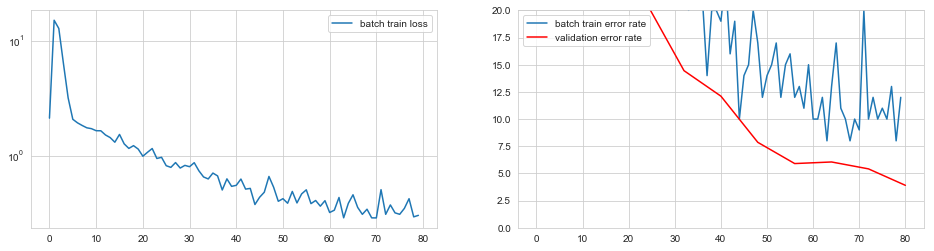

In [8]:
net = alexnet(pretrained=True)

for param in net.parameters():
    param.requires_grad = False
    
net.classifier = empty_classifier(8)

criterion = nn.NLLLoss()
optimizer = optim.Adam(net.classifier.parameters(), lr=0.001)

train(net, batch_loader, optimizer, criterion, num_epochs = 10, cuda = cuda)

In [ ]:
for param in net.parameters():
    param.requires_grad = True
    
optimizer = optim.Adam(net.parameters(), lr=0.001)
train(net, batch_loader, optimizer, criterion, num_epochs = 100, cuda = cuda)

Training the model!
You can interrupt it at any time.
----------------------------------------------------------
After epoch  1 | valid err rate: 51.07% | doing 100 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  2 | valid err rate: 46.34% | doing 100 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  3 | valid err rate: 47.46% | doing 100 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  4 | valid err rate: 44.04% | doing 100 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  5 | valid err rate: 45.80% | doing 100 epochs
----------------------------------------------------------
----------------------------------------------------------
Af